# Requirements

In [1]:
import json
from typing import List, Tuple
from pathlib import Path

In [2]:
import cv2

# Data Loading

In [3]:
import os
print(os.getcwd())

DATA_PATH = Path(os.getcwd()).parent / 'Data'

/Users/ben/Technion/Hackathon Alonim/AlonimHackatonMission/Code


In [4]:
with open(DATA_PATH / "labels/test_line_labels.json", 'r') as f:
    line_labels = json.load(f)

# Naive Solution

Here we present to you a naive approach to solve the task:

Given a sentence, we can split the entire sentence to its characters, and then create a bounding box for each word according to its length in characters.

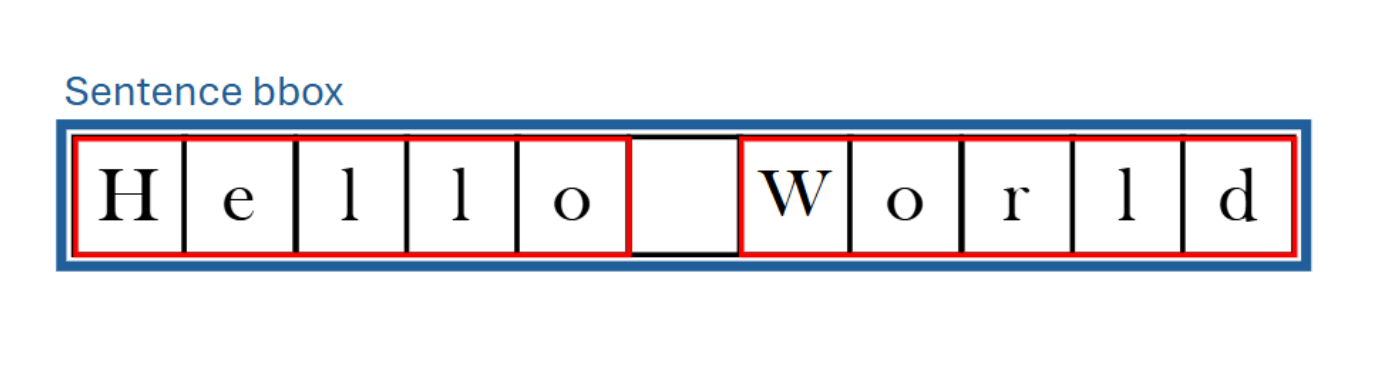

*NOTE: This solution *DOES NOT* use any visual information (the image itself is not in its inputs)


In [5]:
def split_line_to_characters(line_xyxy_bbox: Tuple[float, float, float, float],
                             lines_text: str) -> List[Tuple[float, float, float, float]]:
    '''
    The function computes the bounding boxes of words in a given text.
    Every word's bounding box is computed given its number of characters
    so that every character gets the same length in the text. 
    
    line_xyxy_bbox: the line's bounding box using the format: [xmin, ymin, xmax, ymax]
    lines_text: the text
    
    returns: the words' bounding boxes using the format: [xmin, ymin, xmax, ymax]
    '''
    xmin, ymin, xmax, ymax = line_xyxy_bbox[0], line_xyxy_bbox[1], line_xyxy_bbox[2], line_xyxy_bbox[3]
    w = xmax - xmin
    
    char_num = len(lines_text)
    char_length = w / char_num
    
    words_bboxes = []
    current_xmin = xmin
    
    for word in lines_text.split():
        words_bboxes.append([int(current_xmin), int(ymin), int(current_xmin + len(word) * char_length), int(ymax)])
        current_xmin = current_xmin + (len(word) + 1) * char_length # the + 1 is due to the extra space after each word
    
    return words_bboxes, lines_text.split()[::-1]

# Using the solution and saving as json

In [6]:
pred_dict = {}
for image_name in line_labels.keys():
    bounding_boxes = []
    texts = []
    for i in range(len(line_labels[image_name]['BoundingBoxes'])):
        words_bboxes, words = split_line_to_characters(line_labels[image_name]['BoundingBoxes'][i], line_labels[image_name]['Texts'][i])
        bounding_boxes.extend(words_bboxes)
        texts.extend(words)
    pred_dict[image_name] = {'BoundingBoxes': bounding_boxes, 'Texts': texts}

output_path = Path(os.getcwd()).parent / 'naive_solution_pred.json'
with open(output_path, 'w') as f:
    json.dump(pred_dict, f)


# Evaluation

Now, all that is left is to upload the file in the following app:
https://huggingface.co/spaces/itayhadar/AlonimHackatonEvaluation

You should get the following results

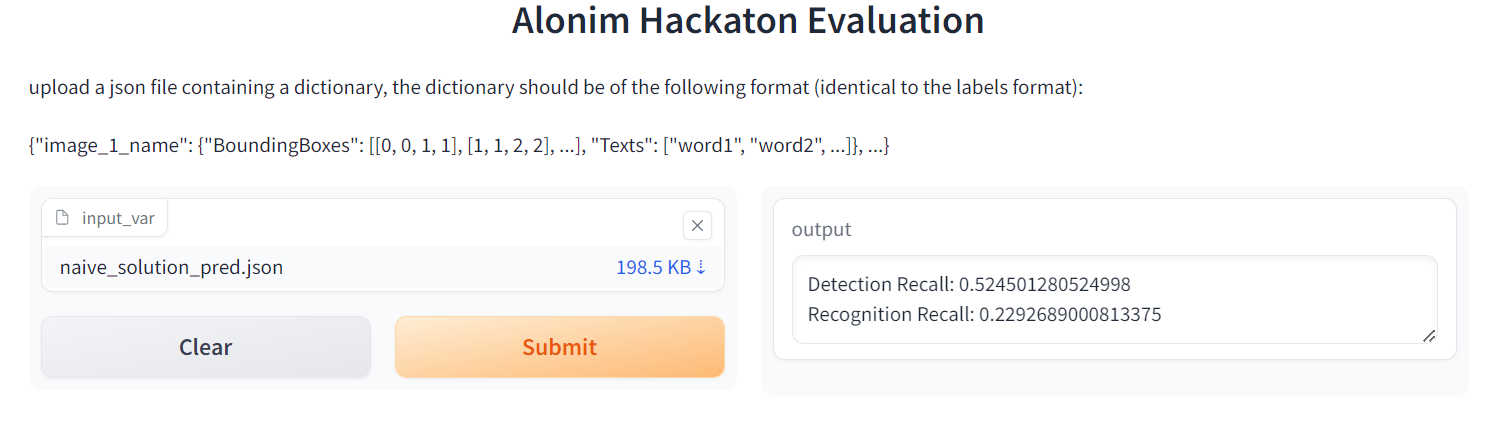

# Baseline to Beat

The naive approach achieves a recognition recall score of 0.229.
This will be the first score to beat - then each other.

Note you have also recieved open source results of textract (amazon) and tesseract (google)

if you submit those results as is you will recieve the following metrics:

### Tesseract - Detection: 0.56, Recognition: 0.109

### Textract - Detection: 0.812, Recognition: 0 (Textract doesn't predict farsi)

# Your Solution

Your algorithm *can* use all the following inputs:

1) Image
2) Line Bounding Boxes
3) Line Texts
4) Open Source OCR results in our format (only boxes and texts)
5) Original Open Source OCR results (containing other metadata predicted such as line-word matching)

NOTE: You don't need to use all inputs. It is even suggested to start with an algorithm that uses only part of the information then see how you improve it with more information later on.

In [7]:
from tqdm import tqdm
import os
import cv2
import pandas as pd
import numpy as np
import json
from typing import Optional, Tuple
import matplotlib.pyplot as plt

In [8]:
def compute_and_visualize_erosion_and_dilation(image: np.ndarray, kernel_size:Tuple[int,int] = (2,2)) -> Tuple[np.ndarray, np.ndarray]:
    image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = np.ones(kernel_size, np.uint8)
    erosion = cv2.erode(gray, kernel, iterations=1)
    dilation = cv2.dilate(gray, kernel, iterations=1)
    return erosion, dilation

In [9]:
def find_and_visualize_corners(image: np.ndarray) ->np.ndarray:
    image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    dst = cv2.dilate(dst, None)
    # get list of all the corners
    corners = np.argwhere(dst > 0.01 * dst.max())
    return corners



In [108]:
def split_line(image, line_labels):
    # for each line
    # look at the image cropped to the bounding box
    # find the harris corners
    # do k means clustering with k = number of words in line
    # for each cluster, find the bounding box from the leftmost to the rightmost corner
    # return the bounding boxes and the text
    line_bboxes = line_labels['BoundingBoxes']
    line_texts = line_labels['Texts']
    words_bboxes = []
    words_texts = []

    for i in range(len(line_bboxes)):
        cropped_image = image[int(line_bboxes[i][1]):int(line_bboxes[i][3]), :]
        plt.imshow(cropped_image)
        corners = find_and_visualize_corners(cropped_image)
        if len(corners) == 0:
            print('bug')
        
        # comnpute number of words in the line
        num_words = len(line_texts[i].split())
        k = num_words
        
        corners_x = corners[:, 1]
        # add 0 and the width of the image to the corners
        corners_x_added = np.append(corners_x, 0)
        corners_x_added = np.append(corners_x_added, cropped_image.shape[1])
        corners_x_added.sort()
        # Calculate the gaps between consecutive elements
        gaps = np.diff(corners_x_added)
        
        # Find the indices of the K+1 largest gaps
        largest_gaps_indices = np.argsort(gaps)[-k-1:][::-1]
        
        # Retrieve the largest gaps along with their intervals
        largest_gaps = [(int(corners_x_added[i]), int(corners_x_added[i+1])) for i in largest_gaps_indices]
        largest_gaps.sort(key=lambda x: x[0])
        regions = []
        for gap_idx in range(len(largest_gaps)-1):
            regions.append([largest_gaps[gap_idx][1]-1, largest_gaps[gap_idx+1][0]])

        labels = np.zeros(len(corners))
        # check for each corner which region it is in - between the right part of a region and the left of the next region
        for corner_idx in range(len(corners)):
            for j in range(len(regions)):
                if corners[corner_idx][1] >= regions[j][0] and corners[corner_idx][1] <= regions[j][1]:
                    labels[i] = j
                    break
            if labels[i] == 0:
                labels[i] = len(regions) - 1
        


        # for each cluster, find the bounding box from the leftmost to the rightmost corner
        for j in range(k):
            # cluster_corners = corners[labels == j]
            # if len(cluster_corners) == 0:
            #     print('bug')
                # visualize the region 
            # leftmost_corner = np.min(cluster_corners[:, 1])
            # rightmost_corner = np.max(cluster_corners[:, 1])
            words_bboxes.append([regions[j][0], line_bboxes[i][1], regions[j][1], line_bboxes[i][3]])
            # words_bboxes.append([leftmost_corner, line_bboxes[i][1], rightmost_corner, line_bboxes[i][3]])
            words_texts.append(line_texts[i].split()[-j-1])

        # flip the words_texts to be in the correct order
        words_texts = words_texts[::-1]



    return {'BoundingBoxes': words_bboxes, 'Texts': words_texts}



In [77]:
def our_split_line_to_characters(line_box: Tuple[float, float, float, float], line_text: str, image) -> List[Tuple[float, float, float, float]]:
    '''
    The function computes the bounding boxes of words in a given text.
    Every word's bounding box is computed given its number of characters
    so that every character gets the same length in the text. 
    
    line_box: the line's bounding box using the format: [xmin, ymin, xmax, ymax]
    line_text: the text
    
    returns: the words' bounding boxes using the format: [xmin, ymin, xmax, ymax]
    '''

    x_min, y_min, x_max, y_max = line_box
    image_cropped = image[y_min:y_max, x_min:x_max]
    # image_cropped, _ = compute_and_visualize_erosion_and_dilation(image_cropped)
    # find spaces in the line by looking for columns with only white pixels for 10 consecutive pixels
    white_columns = []
    for i in range(image_cropped.shape[1]):
        if all(image_cropped[:, i].flatten()):
            white_columns.append(i)
    
    beginning_of_region = 0
    regions = []
    for i in range(1, len(white_columns)):
        if white_columns[i] == white_columns[i-1] + 1:
            continue
        else:
            regions.append((beginning_of_region, white_columns[i-1]))
            beginning_of_region = white_columns[i]
    print(regions)
    regions.append((beginning_of_region, white_columns[-1]))
    boxes = []
    for region in regions:
        x1, x2 = region
        # if x2 - x1 < 10:
        #     continue
        boxes.append((x1, y_min, x2, y_max))
    return boxes
    

    
    

In [37]:
def draw_bounding_boxes(image: np.ndarray, line_labels: Optional[pd.DataFrame]=None, true_word_labels: Optional[pd.DataFrame]=None,
                pred_word_labels: Optional[pd.DataFrame]=None, fill: bool = False) -> np.ndarray:
  thickness = -1 if fill else 2
  for labels, color in zip([line_labels, true_word_labels, pred_word_labels], [(255, 0, 0), (0, 255, 0), (0, 0, 255)]):
    if labels is not None:
      for row in labels:
        image = cv2.rectangle(image, row[:2], row[2:], color, thickness)
  return image

In [38]:
def create_bounding_boxes(images, train_line_labels, textract):
    # pred_dict = {}
    for (image_name, line) in tqdm(train_line_labels.items()):
        bounding_boxes = []
        texts = []
        image_with_boxes = draw_bounding_boxes(images[f'page_{image_name}.png'], textract[image_name]['BoundingBoxes'])
        plt.imshow(image_with_boxes)
        plt.savefig(f'../Data/visualizations/{image_name}.png')
        plt.show() 
        break
    # return pred_dict
    return textract

In [39]:
def look_for_gaps(images, line_labels, textract):
    for (image_name, line) in tqdm(textract.items()):
        image = images[f'page_{image_name}.png']
        new_bounding_boxes = []
        for i in range(1, len(line['BoundingBoxes'])):

            if line['BoundingBoxes'][i][0] - line['BoundingBoxes'][i-1][2] > 25:
                print('here')
                new_bounding_box = (line['BoundingBoxes'][i-1][2], line['BoundingBoxes'][i-1][1], line['BoundingBoxes'][i][0], line['BoundingBoxes'][i][3])
                new_bounding_boxes.append(new_bounding_box)

        image_with_boxes = draw_bounding_boxes(image, new_bounding_boxes)
        print(line['BoundingBoxes'])
        print(len(new_bounding_boxes) + len(line['BoundingBoxes']), len(line_labels[image_name]['BoundingBoxes']))
        plt.imshow(image_with_boxes)
        plt.show()
        break

In [16]:
textract = json.load(open('/Users/ben/Technion/Hackathon Alonim/AlonimHackatonMission/Data/opensource_results/textract/test_textract_results_formatted.json'))
print(textract)

{'00001': {'BoundingBoxes': [[578, 20, 584, 34], [44, 90, 92, 108], [107, 90, 133, 107], [144, 87, 192, 108], [204, 88, 249, 108], [261, 88, 304, 108], [315, 88, 367, 108], [458, 88, 471, 108], [483, 91, 522, 109], [533, 87, 558, 104], [539, 123, 574, 138], [45, 163, 87, 186], [102, 162, 112, 181], [125, 161, 169, 181], [182, 165, 201, 180], [212, 161, 231, 177], [297, 162, 349, 181], [362, 161, 411, 177], [424, 162, 434, 182], [445, 163, 489, 178], [499, 165, 517, 180], [530, 164, 569, 181], [45, 198, 73, 213], [93, 194, 138, 217], [237, 197, 269, 217], [282, 200, 301, 215], [389, 196, 409, 211], [424, 199, 443, 215], [457, 196, 496, 217], [512, 202, 565, 217], [44, 232, 76, 247], [91, 232, 103, 247], [109, 231, 141, 246], [149, 235, 177, 249], [184, 231, 203, 248], [210, 231, 252, 252], [261, 235, 279, 250], [342, 232, 390, 252], [398, 232, 444, 252], [452, 232, 473, 251], [480, 233, 494, 252], [502, 234, 516, 249], [516, 231, 538, 252], [538, 232, 573, 251], [45, 271, 57, 287], [71,

In [43]:
images_path = DATA_PATH / 'images'
images = {}
for image_name in os.listdir(images_path):
    images[image_name] = cv2.imread(str(images_path / image_name))

test_line_labels = json.load(open(DATA_PATH / "labels/test_line_labels.json", 'r'))

In [18]:
test_line_labels

{'00001': {'BoundingBoxes': [[2, 17, 585, 34],
   [2, 85, 585, 115],
   [2, 120, 585, 150],
   [2, 155, 585, 185],
   [2, 190, 585, 220],
   [2, 225, 585, 255],
   [2, 260, 585, 290],
   [2, 295, 585, 325],
   [2, 330, 585, 360],
   [2, 365, 585, 395],
   [2, 400, 585, 430],
   [2, 435, 585, 465],
   [2, 470, 585, 500],
   [2, 505, 585, 535],
   [2, 540, 585, 570],
   [2, 575, 585, 605],
   [2, 610, 585, 640],
   [2, 645, 585, 675],
   [2, 680, 585, 710],
   [2, 735, 585, 765]],
  'Texts': ['1\n',
   '1.8 درصد از خانوارهای خراسان شمالی مشمول دریافت سبد معیشتی\n',
   'شدند\n',
   'نوری در نشست با اصناف خراسان شمالی که در ارتباط با شیوع\n',
   'ویروس کرونا در 20 فروردین در محل استانداری برگزار شد،\n',
   'اظهارکرد: از یک میلیون خانوار موجود در کشور که بسته 200 تا 600\n',
   'هزار تومانی مشمول آن ها شدند، 16 هزار و 800 خانوار متعلق به\n',
   'خراسان شمالی بوده است.\n',
   'وی در ارتباط با بیمه بیکاری نیز بیان کرد: در کشور 320 هزار نفر برای\n',
   'دریافت بیمه بیکاری در زمان شیوع ویروس کرو

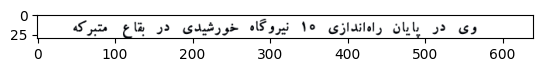

In [109]:
our_solution= {}

for image in test_line_labels:
    image_title = f'page_{image}.png'
    bboxes = split_line(images[image_title], test_line_labels[image])
    our_solution[image] = bboxes


In [ ]:
look_for_gaps(images, test_line_labels, textract)

  0%|          | 0/20 [00:00<?, ?it/s]

here
here
here
here
here
here
here
here
here
[[578, 20, 584, 34], [44, 90, 92, 108], [107, 90, 133, 107], [144, 87, 192, 108], [204, 88, 249, 108], [261, 88, 304, 108], [315, 88, 367, 108], [458, 88, 471, 108], [483, 91, 522, 109], [533, 87, 558, 104], [539, 123, 574, 138], [45, 163, 87, 186], [102, 162, 112, 181], [125, 161, 169, 181], [182, 165, 201, 180], [212, 161, 231, 177], [297, 162, 349, 181], [362, 161, 411, 177], [424, 162, 434, 182], [445, 163, 489, 178], [499, 165, 517, 180], [530, 164, 569, 181], [45, 198, 73, 213], [93, 194, 138, 217], [237, 197, 269, 217], [282, 200, 301, 215], [389, 196, 409, 211], [424, 199, 443, 215], [457, 196, 496, 217], [512, 202, 565, 217], [44, 232, 76, 247], [91, 232, 103, 247], [109, 231, 141, 246], [149, 235, 177, 249], [184, 231, 203, 248], [210, 231, 252, 252], [261, 235, 279, 250], [342, 232, 390, 252], [398, 232, 444, 252], [452, 232, 473, 251], [480, 233, 494, 252], [502, 234, 516, 249], [516, 231, 538, 252], [538, 232, 573, 251], [45, 27

In [106]:
our_solution

{'00001': {'BoundingBoxes': [[578, 17, 583, 34],
   [45, 85, 93, 115],
   [107, 85, 133, 115],
   [144, 85, 192, 115],
   [205, 85, 249, 115],
   [262, 85, 304, 115],
   [316, 85, 368, 115],
   [379, 85, 447, 115],
   [456, 85, 471, 115],
   [483, 85, 521, 115],
   [535, 85, 559, 115],
   [540, 120, 575, 150],
   [46, 155, 87, 185],
   [103, 155, 114, 185],
   [124, 155, 170, 185],
   [181, 155, 200, 185],
   [212, 155, 232, 185],
   [246, 155, 287, 185],
   [298, 155, 351, 185],
   [363, 155, 412, 185],
   [425, 155, 436, 185],
   [447, 155, 489, 185],
   [498, 155, 517, 185],
   [532, 155, 571, 185],
   [46, 190, 74, 220],
   [92, 190, 139, 220],
   [155, 190, 225, 220],
   [238, 190, 269, 220],
   [282, 190, 301, 220],
   [317, 190, 377, 220],
   [390, 190, 410, 220],
   [424, 190, 443, 220],
   [458, 190, 499, 220],
   [513, 190, 565, 220],
   [44, 225, 65, 255],
   [69, 225, 76, 255],
   [92, 225, 105, 255],
   [110, 225, 141, 255],
   [149, 225, 178, 255],
   [184, 225, 204, 255]

In [110]:
with open('our_solution.json', 'w+') as f:
    json.dump(our_solution, f)

## Good Luck!